In [29]:
# ------------------------------------------------------------------
# Definir base_path y lista de archivos explícitamente
# ------------------------------------------------------------------
base_path = "/home/miguelo/molivares/PRUEBA 2"
file_names = [
    "Spain_meteo_dirty_2018_2022.csv",
    "Chile_meteo_dirty_2018_2022.csv",
    "Australia_meteo_dirty_2018_2022.csv"
]


In [34]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

# ------------------------------------------------------------------
# 1)  Función de limpieza y formateo  ► lista para SAM
# ------------------------------------------------------------------
def limpiar_y_preparar_sam(df,
                           columnas      = ['GHI', 'DHI', 'DNI'],
                           max_gap       = 3,
                           expected_rows = 43824,
                           perc_clear    = 0.975):
    """
    • Recorta a `expected_rows`
    • Conserva Timestamp
    • Capa valores extremos por mes‑hora (percentil perc_clear)
    • Interpola huecos cortos (`max_gap` h) y rellena resto con 0
    • Devuelve DF con columnas SAM
    """
    df = df.copy().head(expected_rows)

    if 'Timestamp' not in df.columns:
        raise ValueError("El DataFrame debe contener la columna 'Timestamp'")
    df = df[['Timestamp'] + [c for c in df.columns if c != 'Timestamp']]

    for col in columnas:
        if col not in df.columns:
            df[col] = np.nan

    for col in columnas:
        df[col] = df[col].replace(0, np.nan).mask(df[col] < 0)

    tmp = (df[['Timestamp'] + columnas]
           .melt('Timestamp', var_name='var', value_name='val')
           .dropna())
    tmp['month'] = tmp['Timestamp'].dt.month
    tmp['hour']  = tmp['Timestamp'].dt.hour

    caps = (tmp.groupby(['var','month','hour'])['val']
              .quantile(perc_clear)
              .unstack(['month','hour']))

    full_months = range(1, 13)
    full_hours  = range(0, 24)

    for col in columnas:
        if col in caps.index:
            cap_df_raw = caps.loc[col]
            if isinstance(cap_df_raw, pd.Series):
                cap_df = pd.DataFrame(np.nan, index=full_months, columns=full_hours)
            else:
                cap_df = cap_df_raw
        else:
            cap_df = pd.DataFrame(np.nan, index=full_months, columns=full_hours)

        cap_df = cap_df.reindex(index=full_months, columns=full_hours).astype(float)
        fallback = np.nanmedian(cap_df.values)
        cap_df = cap_df.fillna(fallback)

        cap_mat = cap_df.values
        meses   = df['Timestamp'].dt.month.values - 1
        horas   = df['Timestamp'].dt.hour.values
        df[col] = np.minimum(df[col].values, cap_mat[meses, horas])

    for col in columnas:
        df[col] = (df[col]
                   .interpolate(limit=max_gap, limit_direction='both')
                   .fillna(0))

    df['Year']   = df['Timestamp'].dt.year
    df['Month']  = df['Timestamp'].dt.month
    df['Day']    = df['Timestamp'].dt.day
    df['Hour']   = df['Timestamp'].dt.hour
    df['Minute'] = df['Timestamp'].dt.minute

    df['Temperature'] = 25
    df['Wind Speed']  = 1

    cols_final = ['Timestamp','Year','Month','Day','Hour','Minute',
                  'GHI','DNI','DHI','Temperature','Wind Speed']
    return df[cols_final]

# ------------------------------------------------------------------
# 2)  Procesar CSVs y guardar *_pre_sam.csv
# ------------------------------------------------------------------
base_path = "/home/miguelo/molivares/PRUEBA 2"
file_names = [
    "Spain_meteo_dirty_2018_2022.csv",
    "Chile_meteo_dirty_2018_2022.csv",
    "Australia_meteo_dirty_2018_2022.csv"
]

dataframes = {}
for f in file_names:
    pais = f.split('_')[0]
    ruta = os.path.join(base_path, f)
    df = pd.read_csv(ruta, parse_dates=['Timestamp'])
    dataframes[pais] = df.rename(columns=str.strip)

df_preparados = {p: limpiar_y_preparar_sam(df)
                 for p, df in dataframes.items()}

for pais, df in df_preparados.items():
    out = os.path.join(base_path, f"{pais}_pre_sam.csv")
    df.to_csv(out, index=False)
    print("✅ Guardado:", out)



/tmp/ipykernel_2489/3636068949.py:58: RuntimeWarning: All-NaN slice encountered
  fallback = np.nanmedian(cap_df.values)
/tmp/ipykernel_2489/3636068949.py:58: RuntimeWarning: All-NaN slice encountered
  fallback = np.nanmedian(cap_df.values)
/tmp/ipykernel_2489/3636068949.py:58: RuntimeWarning: All-NaN slice encountered
  fallback = np.nanmedian(cap_df.values)
/tmp/ipykernel_2489/3636068949.py:58: RuntimeWarning: All-NaN slice encountered
  fallback = np.nanmedian(cap_df.values)
/tmp/ipykernel_2489/3636068949.py:58: RuntimeWarning: All-NaN slice encountered
  fallback = np.nanmedian(cap_df.values)
/tmp/ipykernel_2489/3636068949.py:58: RuntimeWarning: All-NaN slice encountered
  fallback = np.nanmedian(cap_df.values)
/tmp/ipykernel_2489/3636068949.py:58: RuntimeWarning: All-NaN slice encountered
  fallback = np.nanmedian(cap_df.values)
/tmp/ipykernel_2489/3636068949.py:58: RuntimeWarning: All-NaN slice encountered
  fallback = np.nanmedian(cap_df.values)
/tmp/ipykernel_2489/3636068949.p

✅ Guardado: /home/miguelo/molivares/PRUEBA 2/Spain_pre_sam.csv
✅ Guardado: /home/miguelo/molivares/PRUEBA 2/Chile_pre_sam.csv
✅ Guardado: /home/miguelo/molivares/PRUEBA 2/Australia_pre_sam.csv


/tmp/ipykernel_2489/3966866839.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .reindex(pd.date_range(start, periods=expected_rows, freq='H'))
/tmp/ipykernel_2489/3966866839.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .reindex(pd.date_range(start, periods=expected_rows, freq='H'))
/tmp/ipykernel_2489/3966866839.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .reindex(pd.date_range(start, periods=expected_rows, freq='H'))


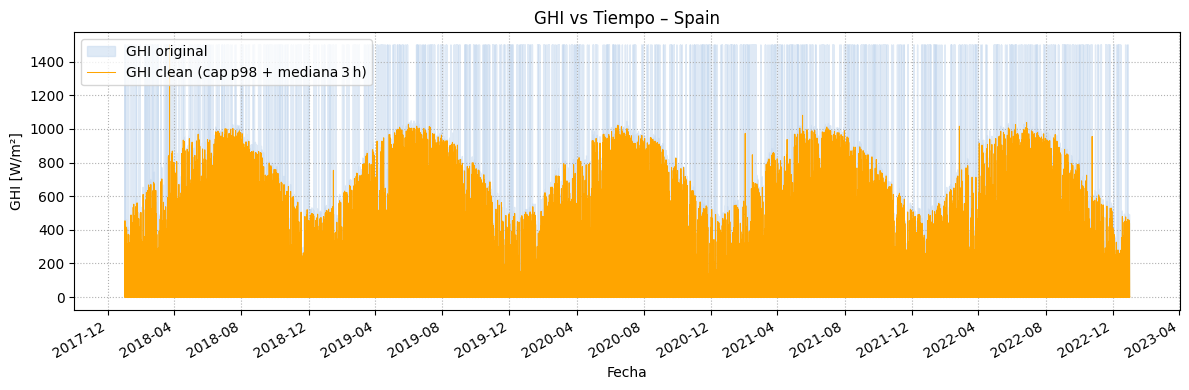

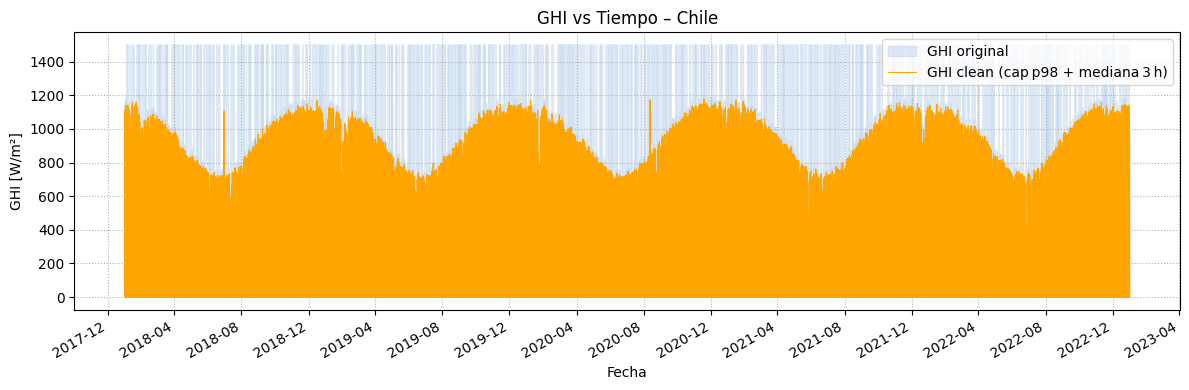

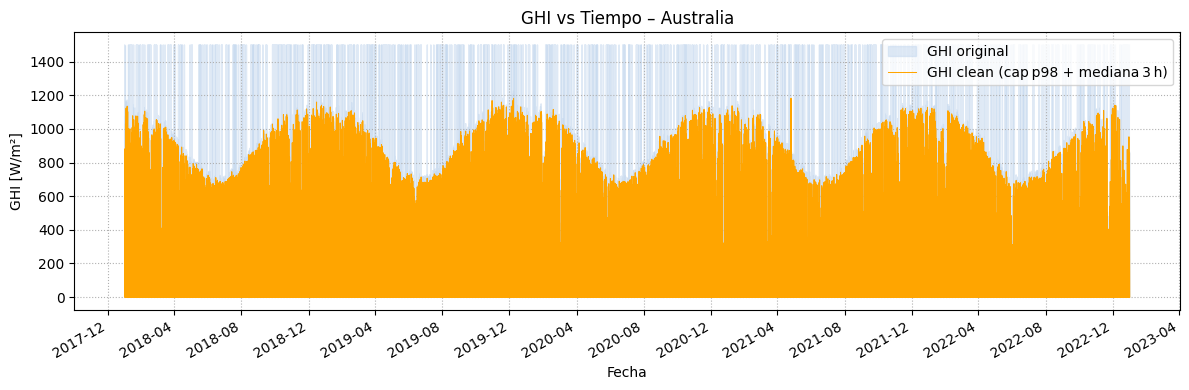

✅ Guardado limpio: /home/miguelo/molivares/PRUEBA 2/Spain_filtrado.csv
✅ Guardado SAM: /home/miguelo/molivares/PRUEBA 2/Spain_sam.csv
✅ Guardado limpio: /home/miguelo/molivares/PRUEBA 2/Chile_filtrado.csv
✅ Guardado SAM: /home/miguelo/molivares/PRUEBA 2/Chile_sam.csv
✅ Guardado limpio: /home/miguelo/molivares/PRUEBA 2/Australia_filtrado.csv
✅ Guardado SAM: /home/miguelo/molivares/PRUEBA 2/Australia_sam.csv


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import os

# ------------------------------------------------------------------
# 0) Definir carpeta base y archivos
# ------------------------------------------------------------------
base_path = "/home/miguelo/molivares/PRUEBA 2"
file_names = [
    "Spain_meteo_dirty_2018_2022.csv",
    "Chile_meteo_dirty_2018_2022.csv",
    "Australia_meteo_dirty_2018_2022.csv"
]

# ------------------------------------------------------------------
# 1)  Cargar los CSV originales
# ------------------------------------------------------------------
dataframes = {}
for file in file_names:
    country   = file.split('_')[0]
    df_raw    = pd.read_csv(os.path.join(base_path, file), parse_dates=['Timestamp'])
    dataframes[country] = df_raw.rename(columns=str.strip)

# ------------------------------------------------------------------
# 2)  Función robusta: cap‑percentil + mediana 3 h   (GHI y DHI)
# ------------------------------------------------------------------
def limpiar_ghi_dhi(df, expected_rows=43824, p_clear=0.975, win_med=4):
    """
    Devuelve el DF con todas las columnas originales + GHI_clean y DHI_clean.
    - p_clear   : percentil que define la ‘envolvente despejado’ mes‑hora
    - win_med   : ancho de la mediana deslizante (h)
    """
    # --- a) índice horario continuo ---
    start = df['Timestamp'].min()
    full  = (df.set_index('Timestamp')
               .reindex(pd.date_range(start, periods=expected_rows, freq='H'))
               .rename_axis('Timestamp'))
    full.reset_index(inplace=True)

    for var in ['GHI', 'DHI']:
        if var not in full.columns:
            full[var] = np.nan

        # --- b) valores base ---
        s0 = full[var].copy()
        s0 = s0.mask(s0 < 0, np.nan)

        # --- c) envolvente despejado (mes, hora) ---
        tmp          = s0.to_frame(var)
        tmp['Month'] = full['Timestamp'].dt.month
        tmp['Hour']  = full['Timestamp'].dt.hour
        env          = (tmp.dropna()
                           .groupby(['Month', 'Hour'])[var]
                           .quantile(p_clear)
                           .unstack())

        months = full['Timestamp'].dt.month.values - 1
        hours  = full['Timestamp'].dt.hour.values
        caps   = env.values[months, hours]

        s_cap = np.minimum(s0.values, caps)

        # --- d) mediana deslizante centrada ---
        s_med = (pd.Series(s_cap, index=full['Timestamp'])
                   .rolling(window=win_med, center=True, min_periods=1)
                   .median())

        full[f'{var}_clean'] = s_med.fillna(0).values

    return full

# ------------------------------------------------------------------
# 3)  Procesar
# ------------------------------------------------------------------
df_proc = {c: limpiar_ghi_dhi(df) for c, df in dataframes.items()}

# ------------------------------------------------------------------
# 4)  Graficar (ejemplo solo GHI)
# ------------------------------------------------------------------
for pais, df in df_proc.items():
    plt.figure(figsize=(12,4))
    plt.fill_between(df['Timestamp'], df['GHI'], color='#c6d9ef', alpha=0.55, label='GHI original')
    plt.plot(df['Timestamp'], df['GHI_clean'], lw=0.75, color='orange',
             label='GHI clean (cap p98 + mediana 3 h)')
    plt.title(f'GHI vs Tiempo – {pais}')
    plt.xlabel('Fecha'); plt.ylabel('GHI [W/m²]')
    plt.grid(True, ls=':')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    plt.legend(); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------
# 5)  Guardar CSV ya limpios: «<pais>_filtrado.csv»
# ------------------------------------------------------------------

parametros_geo = {
    "Spain":     {"lat": 40.4,  "lon": -3.7,   "tz": 1,  "elev": 667, "site": "ESP_Site"},
    "Chile":     {"lat": -23.0, "lon": -70.4,  "tz": -4, "elev": 1259, "site": "CHL_Site"},
    "Australia": {"lat": -33.9, "lon": 151.2,  "tz": 10, "elev": 75,  "site": "AUS_Site"}
}

for pais, df in df_proc.items():
    # Guardar CSV limpio original
    out_clean = os.path.join(base_path, f'{pais}_filtrado.csv')
    df.to_csv(out_clean, index=False)
    print(f"✅ Guardado limpio: {out_clean}")

    # Crear DataFrame con columnas esperadas por SAM
    df_sam = pd.DataFrame()
    df_sam['Year']   = df['Timestamp'].dt.year
    df_sam['Month']  = df['Timestamp'].dt.month
    df_sam['Day']    = df['Timestamp'].dt.day
    df_sam['Hour']   = df['Timestamp'].dt.hour
    df_sam['Minute'] = df['Timestamp'].dt.minute
    df_sam['GHI']    = df.get('GHI_clean', 0)
    df_sam['DNI']    = 0.0  # No disponible desde el filtro
    df_sam['DHI']    = df.get('DHI_clean', 0)
    df_sam['Tdry']   = 25.0
    df_sam['RH']     = 50.0
    df_sam['Pres']   = 101325.0
    df_sam['Wspd']   = 1.0
    df_sam['Wdir']   = 180.0
    df_sam['Hour']   = df['Timestamp'].dt.hour.astype(int)
    df_sam['Minute'] = df['Timestamp'].dt.minute.astype(int)

    # Guardar archivo SAM con encabezado 
    out_sam = os.path.join(base_path, f'{pais}_sam.csv')
    with open(out_sam, 'w') as f:
        meta = parametros_geo[pais]
        # Línea 1: metadatos
        f.write("Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation\n")
        f.write(f"CPARRADO,00000,{meta['site']},NA,{pais.upper()},{meta['lat']},{meta['lon']},{meta['tz']},{meta['elev']}\n")
        # Línea 2: encabezados SAM
        columnas = ['Year','Month','Day','Hour','Minute','GHI','DNI','DHI','Tdry','RH','Pres','Wspd','Wdir']
        f.write(",".join(columnas) + "\n")
        # Datos
        df_sam.to_csv(f, index=False, header=False)

    print(f"✅ Guardado SAM: {out_sam}")


In [99]:
import PySAM.Pvsamv1 as pvsam
import pandas as pd
import os

# ---------------------- CONFIGURACIÓN ----------------------
base_path = "/home/miguelo/molivares/PRUEBA 2"
paises = ["Spain", "Chile", "Australia"]

capacidad_kw = 50000  # 50 MW
analisis_anios = 1    # 1 año de simulación

# -------------------- ITERACIÓN POR PAÍS -------------------
for pais in paises:
    print(f"\n🔧 Simulando {pais}...")

    archivo_sam = os.path.join(base_path, f"{pais}_sam.csv")

    # Crear modelo
    mod = pvsam.default("FlatPlatePVCommercial")
    mod.SolarResource.solar_resource_file = archivo_sam
    mod.SystemDesign.system_capacity = capacidad_kw
    mod.Lifetime.analysis_period = analisis_anios

    # Ejecutar simulación
    mod.execute()

    # Leer timestamps desde el CSV filtrado
    archivo_filtrado = os.path.join(base_path, f"{pais}_filtrado.csv")
    df_tiempo = pd.read_csv(archivo_filtrado, parse_dates=["Timestamp"])

    df_out = pd.DataFrame({
        "Timestamp": df_tiempo["Timestamp"].iloc[:len(mod.Outputs.ac)],
        "AC_kW": mod.Outputs.ac
    })

    salida = os.path.join(base_path, f"{pais}_PV_50MW_AC_pvsam.csv")
    df_out.to_csv(salida, index=False)
    print(f"✅ Guardado: {salida}")




🔧 Simulando Spain...


Exception: pvsamv1 execution error.
	exec fail(pvsamv1): latitude and longitude required but not specified

